© 2024 Nokia
Licensed under the BSD 3 Clause Clear License  
SPDX-License-Identifier: BSD-3-Clause-Clear

In [110]:
from itertools import combinations

import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn import metrics
from statannotations.Annotator import Annotator

# Evaluation with bootstrapping
# np.random.seed(1234)
# rng = np.random.RandomState(1234)
np.random.seed(2)
rng = np.random.RandomState(2)

# font import
import matplotlib.font_manager as fm
# Add every font at the specified location
font_dir = [os.path.join('..', '..', '..', 'Work_Sans', 'static')]
for font in fm.findSystemFonts(font_dir):
    fm.fontManager.addfont(font)

# print(fm.findSystemFonts(fontpaths=None, fontext='ttf'))

# sns.set(font="Meiryo")
# sns.set_theme(style='white')
sns.set(style='white', context="poster", font='Work Sans Regural')
# Set font family globally
# sns.set(font='Work Sans')
# sns.set(font_scale = 1.5)

In [111]:
# https://sites.google.com/site/lisaywtang/tech/python/scikit/auc-conf-interval
def get_ci_auc(y_true, y_pred, metric='roc'):
    from scipy.stats import sem
    from sklearn.metrics import roc_auc_score
    n_bootstraps = 500
    bootstrapped_scores = []
    for i in range(n_bootstraps):
        # bootstrap by sampling with replacement on the prediction indices
        indices = rng.random_integers(0, len(y_pred) - 1, len(y_pred))
        # indices = rng.randint(0, len(y_pred) + 1)

        if len(np.unique(y_true[indices])) < 2:
            # We need at least one positive and one negative sample for ROC AUC
            # to be defined: reject the sample
            continue

        score = roc_auc_score(y_true[indices,1], y_pred[indices,1], average='micro')

        bootstrapped_scores.append(score)

    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]

    return confidence_lower, confidence_upper

In [112]:
# dataset = 'MESA'
# # dataset = 'MESA_AUC'
# has_underscore = ''
# df = pd.read_excel(os.path.join(dataset, 'fairness_metrics.xlsx'), engine='openpyxl')

In [113]:
# dataset = 'GLOBEM'
# has_underscore = ''
# df = pd.read_excel(os.path.join(dataset, 'fairness_metrics.xlsx'), engine='openpyxl')
# perf_df = pd.read_excel(os.path.join(dataset, 'ci_metrics.xlsx'), engine='openpyxl')

In [114]:
dataset = 'MIMIC'
has_underscore = ''
# for data efficiency visualizations, else ''
prefix = 'SS_'
df = pd.read_csv(os.path.join(dataset, '{}fairness_metrics.csv'.format(prefix)))
per = pd.read_csv(os.path.join(dataset, '{}ci_metrics.csv'.format(prefix)))

In [115]:
df

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag
0,LANGUAGE,statistical_parity_difference,0.092672,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
1,LANGUAGE,disparate_impact,2.008159,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
2,LANGUAGE,equal_opportunity_difference,0.196484,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
3,LANGUAGE,average_absolute_odds_difference,0.132196,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
4,LANGUAGE,error_rate_difference,0.083311,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
...,...,...,...,...,...,...,...,...,...
523,AGE,false_discovery_rate_ratio,0.831184,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150
524,AGE,false_negative_rate_ratio,0.914010,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150
525,AGE,false_omission_rate_ratio,1.550552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150
526,AGE,false_positive_rate_ratio,0.913782,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150


In [116]:
# keep only ratio metrics for comparison purposes
# 'false_omission_rate_ratio',
df = df[df.metric.isin(['false_omission_rate_ratio', 'disparate_impact', 'error_rate_ratio', 'false_discovery_rate_ratio', 'false_negative_rate_ratio', 'false_positive_rate_ratio'])]
df

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag
1,LANGUAGE,disparate_impact,2.008159,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
5,LANGUAGE,error_rate_ratio,1.555921,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
6,LANGUAGE,false_discovery_rate_ratio,0.815500,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
7,LANGUAGE,false_negative_rate_ratio,0.769209,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
8,LANGUAGE,false_omission_rate_ratio,1.629450,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
...,...,...,...,...,...,...,...,...,...
522,AGE,error_rate_ratio,0.940552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150
523,AGE,false_discovery_rate_ratio,0.831184,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150
524,AGE,false_negative_rate_ratio,0.914010,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150
525,AGE,false_omission_rate_ratio,1.550552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150


In [117]:
# Calculate deviation from statistical parity (1.0)
df.loc[:, "value"].astype(float)
df.loc[:, "Parity Deviation"] = abs(1-df.value)
df

C:\Users\syfan\PycharmProjects\TFC-pretraining\venv\lib\site-packages\pandas\core\indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Parity Deviation
1,LANGUAGE,disparate_impact,2.008159,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,1.008159
5,LANGUAGE,error_rate_ratio,1.555921,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.555921
6,LANGUAGE,false_discovery_rate_ratio,0.815500,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.184500
7,LANGUAGE,false_negative_rate_ratio,0.769209,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.230791
8,LANGUAGE,false_omission_rate_ratio,1.629450,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.629450
...,...,...,...,...,...,...,...,...,...,...
522,AGE,error_rate_ratio,0.940552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.059448
523,AGE,false_discovery_rate_ratio,0.831184,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.168816
524,AGE,false_negative_rate_ratio,0.914010,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.085990
525,AGE,false_omission_rate_ratio,1.550552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.550552


In [118]:
# remove certain tags
df = df[df.tag != 'finetuned2']
df.loc[:, 'Frozen Layers'] = df.tag.apply(lambda t: 'sup.' if t=='supervised' else ('0' if t=='frozen0' else ('1 (f)' if t=='frozen1' else ('1 (m)' if t=='frozen1{}m'.format(has_underscore) else ('2 (f-m)' if t=='frozen2' else ('2 (f-l)' if t=='frozen2{}fl'.format(has_underscore) else '3'))))))
df

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Parity Deviation,Frozen Layers
1,LANGUAGE,disparate_impact,2.008159,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,1.008159,3
5,LANGUAGE,error_rate_ratio,1.555921,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.555921,3
6,LANGUAGE,false_discovery_rate_ratio,0.815500,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.184500,3
7,LANGUAGE,false_negative_rate_ratio,0.769209,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.230791,3
8,LANGUAGE,false_omission_rate_ratio,1.629450,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.629450,3
...,...,...,...,...,...,...,...,...,...,...,...
522,AGE,error_rate_ratio,0.940552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.059448,3
523,AGE,false_discovery_rate_ratio,0.831184,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.168816,3
524,AGE,false_negative_rate_ratio,0.914010,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.085990,3
525,AGE,false_omission_rate_ratio,1.550552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.550552,3


In [119]:
df.tag.value_counts()

frozen1m10     36
frozen1m20     36
frozen1m40     36
frozen1m60     36
frozen1m80     36
frozen1m100    36
frozen1m125    36
frozen1m150    36
Name: tag, dtype: int64

In [120]:
def human_format(num):
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    return int('%.0f' % (num))
    # return '%.0f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])

In [121]:
df.loc[:, "Trainable Parameters"] = df.parameters.apply(lambda p: human_format(p))

In [122]:
# get pairs for statistical testing
model_order = order=['sup.', '0 (⚫⚫⚫)', '1 (⚫⚪⚫)', '1 (⚪⚫⚫)', '2 (⚪⚪⚫)', '2 (⚪⚫⚪)', '3 (⚪⚪⚪)']
pairs = list(combinations(model_order, r=2))
pairs

[('sup.', '0 (⚫⚫⚫)'),
 ('sup.', '1 (⚫⚪⚫)'),
 ('sup.', '1 (⚪⚫⚫)'),
 ('sup.', '2 (⚪⚪⚫)'),
 ('sup.', '2 (⚪⚫⚪)'),
 ('sup.', '3 (⚪⚪⚪)'),
 ('0 (⚫⚫⚫)', '1 (⚫⚪⚫)'),
 ('0 (⚫⚫⚫)', '1 (⚪⚫⚫)'),
 ('0 (⚫⚫⚫)', '2 (⚪⚪⚫)'),
 ('0 (⚫⚫⚫)', '2 (⚪⚫⚪)'),
 ('0 (⚫⚫⚫)', '3 (⚪⚪⚪)'),
 ('1 (⚫⚪⚫)', '1 (⚪⚫⚫)'),
 ('1 (⚫⚪⚫)', '2 (⚪⚪⚫)'),
 ('1 (⚫⚪⚫)', '2 (⚪⚫⚪)'),
 ('1 (⚫⚪⚫)', '3 (⚪⚪⚪)'),
 ('1 (⚪⚫⚫)', '2 (⚪⚪⚫)'),
 ('1 (⚪⚫⚫)', '2 (⚪⚫⚪)'),
 ('1 (⚪⚫⚫)', '3 (⚪⚪⚪)'),
 ('2 (⚪⚪⚫)', '2 (⚪⚫⚪)'),
 ('2 (⚪⚪⚫)', '3 (⚪⚪⚪)'),
 ('2 (⚪⚫⚪)', '3 (⚪⚪⚪)')]

In [123]:
label_pairs = {'sup.': 'sup.', '0': '0 (⚫⚫⚫)', '1 (m)': '1 (⚫⚪⚫)', '1 (f)': '1 (⚪⚫⚫)', '2 (f-l)': '2 (⚪⚫⚪)', '2 (f-m)': '2 (⚪⚪⚫)', '3': '3 (⚪⚪⚪)'}
df.loc[:, "label_frozen"] = df["Frozen Layers"].apply(lambda v: label_pairs.get(v))
df

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Parity Deviation,Frozen Layers,Trainable Parameters,label_frozen
1,LANGUAGE,disparate_impact,2.008159,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,1.008159,3,120,3 (⚪⚪⚪)
5,LANGUAGE,error_rate_ratio,1.555921,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.555921,3,120,3 (⚪⚪⚪)
6,LANGUAGE,false_discovery_rate_ratio,0.815500,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.184500,3,120,3 (⚪⚪⚪)
7,LANGUAGE,false_negative_rate_ratio,0.769209,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.230791,3,120,3 (⚪⚪⚪)
8,LANGUAGE,false_omission_rate_ratio,1.629450,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.629450,3,120,3 (⚪⚪⚪)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,AGE,error_rate_ratio,0.940552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.059448,3,120,3 (⚪⚪⚪)
523,AGE,false_discovery_rate_ratio,0.831184,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.168816,3,120,3 (⚪⚪⚪)
524,AGE,false_negative_rate_ratio,0.914010,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.085990,3,120,3 (⚪⚪⚪)
525,AGE,false_omission_rate_ratio,1.550552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.550552,3,120,3 (⚪⚪⚪)


## Plotting all fairness metrics and attributes together

In [78]:
df = df[df.metric.isin(['false_omission_rate_ratio', 'disparate_impact', 'error_rate_ratio', 'false_discovery_rate_ratio', 'false_negative_rate_ratio', 'false_positive_rate_ratio'])]

In [79]:
df.groupby('label_frozen')['Parity Deviation'].std()

label_frozen
0 (⚫⚫⚫)    0.136409
1 (⚪⚫⚫)    0.157170
1 (⚫⚪⚫)    0.181255
2 (⚪⚪⚫)    0.149404
2 (⚪⚫⚪)    0.203224
3 (⚪⚪⚪)    0.172519
sup.       0.215227
Name: Parity Deviation, dtype: float64

In [80]:
set(df['label_frozen'])

{'0 (⚫⚫⚫)', '1 (⚪⚫⚫)', '1 (⚫⚪⚫)', '2 (⚪⚪⚫)', '2 (⚪⚫⚪)', '3 (⚪⚪⚪)', 'sup.'}

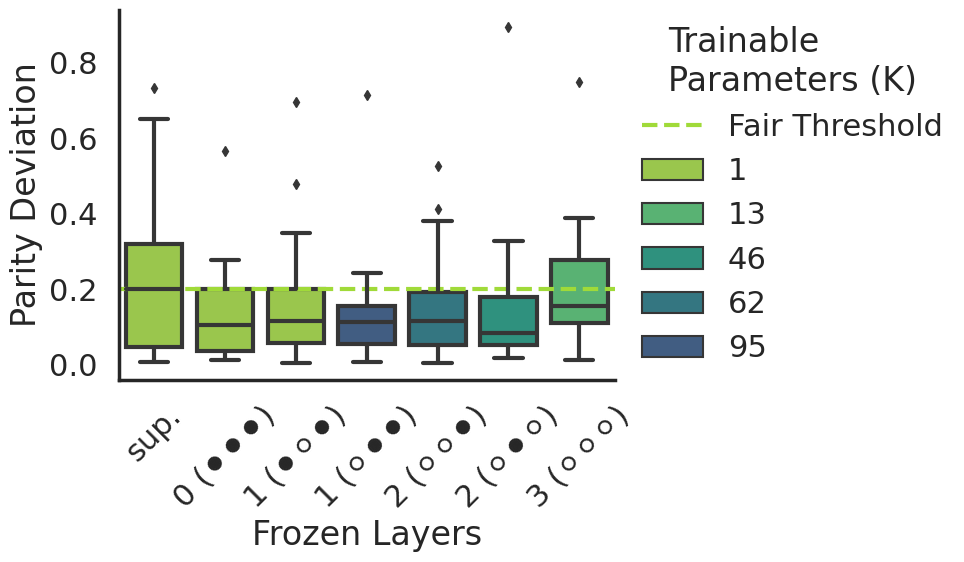

In [81]:
# sns.set_palette(sns.color_palette("viridis", n_colors=6))
sns.set_palette(reversed(sns.color_palette("viridis", n_colors=6)), 6)

# plt.rcParams['legend.title_fontsize'] = 'x-small'
plt.axhline(0.2, ls='--', label='Fair Threshold')
# plt.text(0.11,-0.65,'Fairness Threshold',rotation=0)
ax = sns.boxplot(data=df, x="label_frozen", y="Parity Deviation", hue='Trainable Parameters', order=model_order, dodge=False)
# annotation for statistical testing
# annotator = Annotator(ax, pairs, data=df, x="label_frozen", y="Parity Deviation", order=model_order)
# annotator.configure(test="t-test_paired", hide_non_significant=True)
# annotator.apply_and_annotate()
# appearance
# handles, labels = ax.get_legend_handles_labels()
# labels_sorted, handles_sorted = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))
# ax.legend(handles_sorted, labels_sorted, title="Trainable\nParameters", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.legend(title="Trainable\nParameters (K)", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.xticks(rotation=45)
plt.xlabel('Frozen Layers')
plt.grid(False)
sns.despine()
plt.savefig(os.path.join(dataset, 'fairnessMetricsAll.pdf'), bbox_inches='tight')

In [82]:
grouped = df.groupby('label_frozen')['Parity Deviation'].mean()
grouped

label_frozen
0 (⚫⚫⚫)    0.137345
1 (⚪⚫⚫)    0.142655
1 (⚫⚪⚫)    0.169522
2 (⚪⚪⚫)    0.151196
2 (⚪⚫⚪)    0.157931
3 (⚪⚪⚪)    0.209245
sup.       0.225180
Name: Parity Deviation, dtype: float64

In [37]:
# considering a subset of metrics
# , 'error_rate_ratio' 'false_negative_rate_ratio'
df_sub = df[df['metric'].isin(['error_rate_ratio'])]
df_sub

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Parity Deviation,Frozen Layers,Trainable Parameters,label_frozen
5,nsrr_age_gt89,error_rate_ratio,0.533727,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.466273,2 (f-l),46,2 (⚪⚫⚪)
16,nsrr_age_gt65,error_rate_ratio,0.949060,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.050940,2 (f-l),46,2 (⚪⚫⚪)
27,nsrr_sex,error_rate_ratio,0.977369,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.022631,2 (f-l),46,2 (⚪⚫⚪)
38,nsrr_race,error_rate_ratio,0.944400,45506,simclr.frozen.16.12.hdf5,20231201-084504_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.055600,2 (f-l),46,2 (⚪⚫⚪)
49,nsrr_age_gt89,error_rate_ratio,0.809870,65794,simclr.frozen.16.93.hdf5,20231201-085552_e200_esTrue_bs128_wTrue_f1_m,2,1.0,frozen1m,0.190130,1 (m),66,1 (⚫⚪⚫)
60,nsrr_age_gt65,error_rate_ratio,0.966572,65794,simclr.frozen.16.93.hdf5,20231201-085552_e200_esTrue_bs128_wTrue_f1_m,2,1.0,frozen1m,0.033428,1 (m),66,1 (⚫⚪⚫)
71,nsrr_sex,error_rate_ratio,0.983495,65794,simclr.frozen.16.93.hdf5,20231201-085552_e200_esTrue_bs128_wTrue_f1_m,2,1.0,frozen1m,0.016505,1 (m),66,1 (⚫⚪⚫)
82,nsrr_race,error_rate_ratio,0.980216,65794,simclr.frozen.16.93.hdf5,20231201-085552_e200_esTrue_bs128_wTrue_f1_m,2,1.0,frozen1m,0.019784,1 (m),66,1 (⚫⚪⚫)
93,nsrr_age_gt89,error_rate_ratio,0.863431,98626,simclr.frozen.6.26.hdf5,20231201-090723_e200_esTrue_bs128_wTrue_f0,2,0.0,frozen0,0.136569,0,99,0 (⚫⚫⚫)
104,nsrr_age_gt65,error_rate_ratio,0.964672,98626,simclr.frozen.6.26.hdf5,20231201-090723_e200_esTrue_bs128_wTrue_f0,2,0.0,frozen0,0.035328,0,99,0 (⚫⚫⚫)


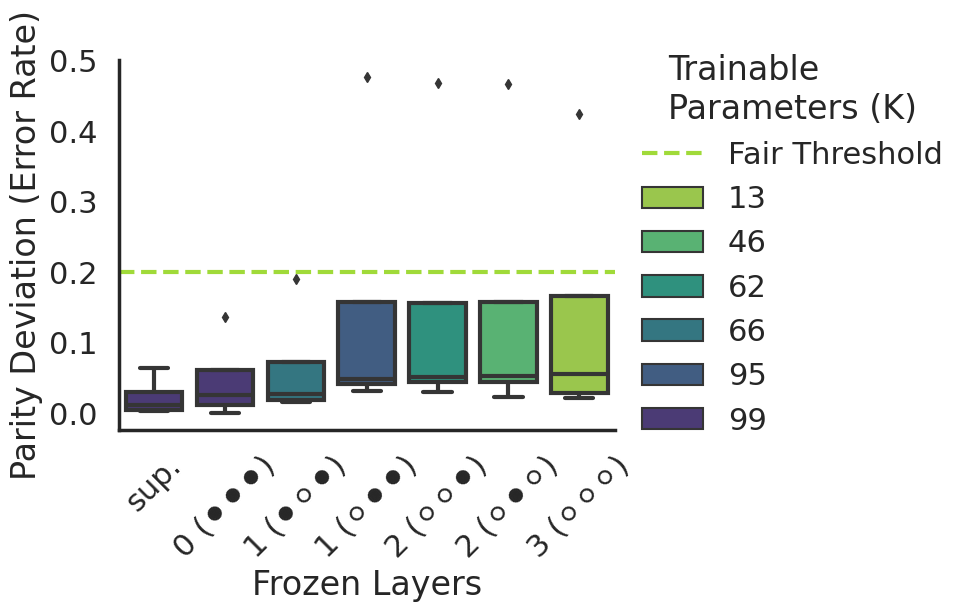

In [38]:
sns.set_palette(reversed(sns.color_palette("viridis", n_colors=6)), 6)

# plt.rcParams['legend.title_fontsize'] = 'x-small'
plt.axhline(0.2, ls='--', label='Fair Threshold')
# plt.text(0.11,-0.65,'Fairness Threshold',rotation=0)
ax = sns.boxplot(data=df_sub, x="label_frozen", y="Parity Deviation", hue='Trainable Parameters', order=model_order, dodge=False)
# annotation for statistical testing
# annotator = Annotator(ax, pairs, data=df_sub, x="label_frozen", y="Parity Deviation", order=model_order)
# annotator.configure(test="t-test_paired", hide_non_significant=True)
# annotator.apply_and_annotate()
# test value should be a StatTest instance or one of the following strings: t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal, Brunner-Munzel
# appearance
# handles, labels = ax.get_legend_handles_labels()
# labels_sorted, handles_sorted = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))
# ax.legend(handles_sorted, labels_sorted, title="Trainable\nParameters", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.legend(title="Trainable\nParameters (K)", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.xticks(rotation=45)
plt.xlabel('Frozen Layers')
plt.ylabel('Parity Deviation (Error Rate)')
plt.grid(False)
sns.despine()
plt.savefig(os.path.join(dataset, 'fairnessMetricsErrorRateSS.pdf'), bbox_inches='tight')

In [ ]:
grouped = df.groupby('label_frozen')['Parity Deviation'].mean()
grouped

In [ ]:
dataset

## Second fairness metric

In [31]:
df

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Parity Deviation,Frozen Layers,Trainable Parameters,label_frozen
1,gender,disparate_impact,1.018705,45506,simclr.frozen.1.41.hdf5,20231128-152529_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.018705,2 (f-l),46,2 (⚪⚫⚪)
2,gender,equal_opportunity_difference,-0.060119,45506,simclr.frozen.1.41.hdf5,20231128-152529_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,1.060119,2 (f-l),46,2 (⚪⚫⚪)
3,gender,average_absolute_odds_difference,0.051920,45506,simclr.frozen.1.41.hdf5,20231128-152529_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.948080,2 (f-l),46,2 (⚪⚫⚪)
5,gender,error_rate_ratio,1.039402,45506,simclr.frozen.1.41.hdf5,20231128-152529_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.039402,2 (f-l),46,2 (⚪⚫⚪)
6,gender,false_discovery_rate_ratio,0.816769,45506,simclr.frozen.1.41.hdf5,20231128-152529_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.183231,2 (f-l),46,2 (⚪⚫⚪)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,disability,average_absolute_odds_difference,0.098635,1162306,supervised.finetuned.hdf5,20231115-091914_l2_e200_esTrue_bs64_wTrue,2,NaN,supervised,0.901365,sup.,1,sup.
225,disability,error_rate_ratio,0.749955,1162306,supervised.finetuned.hdf5,20231115-091914_l2_e200_esTrue_bs64_wTrue,2,NaN,supervised,0.250045,sup.,1,sup.
226,disability,false_discovery_rate_ratio,1.007267,1162306,supervised.finetuned.hdf5,20231115-091914_l2_e200_esTrue_bs64_wTrue,2,NaN,supervised,0.007267,sup.,1,sup.
227,disability,false_negative_rate_ratio,0.956880,1162306,supervised.finetuned.hdf5,20231115-091914_l2_e200_esTrue_bs64_wTrue,2,NaN,supervised,0.043120,sup.,1,sup.


In [32]:
# considering a subset of metrics
# , 'error_rate_ratio' 'false_negative_rate_ratio'
df_sub = df[df['metric'].isin(['average_absolute_odds_difference'])]
df_sub.loc[:, "Parity Deviation"] = df_sub.value
df_sub

C:\Users\syfan\PycharmProjects\TFC-pretraining\venv\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Parity Deviation,Frozen Layers,Trainable Parameters,label_frozen
3,gender,average_absolute_odds_difference,0.051920,45506,simclr.frozen.1.41.hdf5,20231128-152529_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.051920,2 (f-l),46,2 (⚪⚫⚪)
14,race,average_absolute_odds_difference,0.056615,45506,simclr.frozen.1.41.hdf5,20231128-152529_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.056615,2 (f-l),46,2 (⚪⚫⚪)
25,disability,average_absolute_odds_difference,0.037660,45506,simclr.frozen.1.41.hdf5,20231128-152529_e200_esTrue_bs128_wTrue_f2_fl,2,2.0,frozen2fl,0.037660,2 (f-l),46,2 (⚪⚫⚪)
36,gender,average_absolute_odds_difference,0.018064,1129474,simclr.frozen.1.58.hdf5,20231128-152400_e200_esTrue_bs128_wTrue_f1_m,2,1.0,frozen1m,0.018064,1 (m),1,1 (⚫⚪⚫)
47,race,average_absolute_odds_difference,0.078161,1129474,simclr.frozen.1.58.hdf5,20231128-152400_e200_esTrue_bs128_wTrue_f1_m,2,1.0,frozen1m,0.078161,1 (m),1,1 (⚫⚪⚫)
58,disability,average_absolute_odds_difference,0.129497,1129474,simclr.frozen.1.58.hdf5,20231128-152400_e200_esTrue_bs128_wTrue_f1_m,2,1.0,frozen1m,0.129497,1 (m),1,1 (⚫⚪⚫)
69,gender,average_absolute_odds_difference,0.007495,1162306,simclr.frozen.1.56.hdf5,20231128-152548_e200_esTrue_bs128_wTrue_f0,2,0.0,frozen0,0.007495,0,1,0 (⚫⚫⚫)
80,race,average_absolute_odds_difference,0.012206,1162306,simclr.frozen.1.56.hdf5,20231128-152548_e200_esTrue_bs128_wTrue_f0,2,0.0,frozen0,0.012206,0,1,0 (⚫⚫⚫)
91,disability,average_absolute_odds_difference,0.080521,1162306,simclr.frozen.1.56.hdf5,20231128-152548_e200_esTrue_bs128_wTrue_f0,2,0.0,frozen0,0.080521,0,1,0 (⚫⚫⚫)
102,gender,average_absolute_odds_difference,0.042126,94754,simclr.frozen.1.08.hdf5,20231128-152601_e200_esTrue_bs128_wTrue_f1,2,1.0,frozen1,0.042126,1 (f),95,1 (⚪⚫⚫)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04


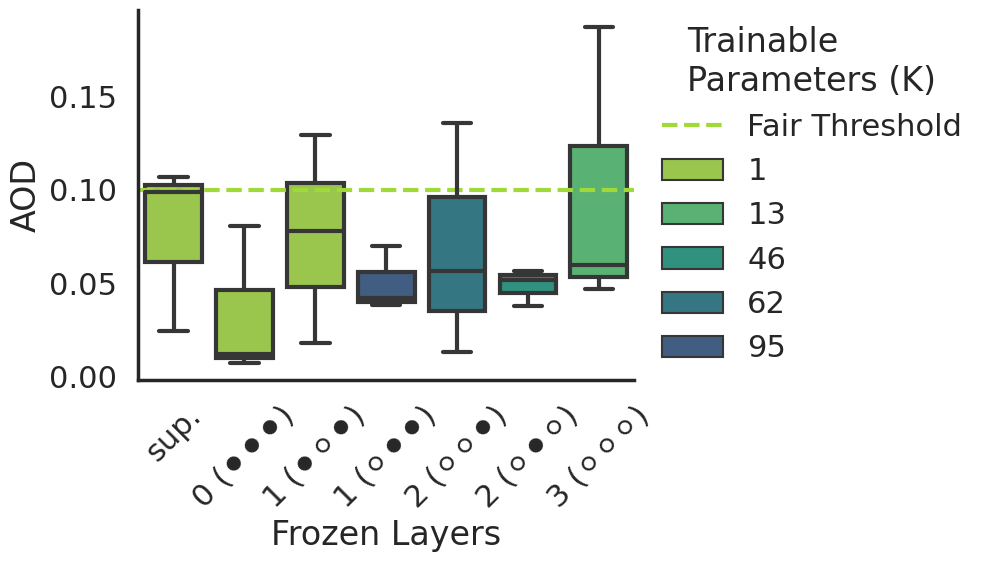

In [33]:
sns.set_palette(reversed(sns.color_palette("viridis", n_colors=6)), 6)

# plt.rcParams['legend.title_fontsize'] = 'x-small'
plt.axhline(0.1, ls='--', label='Fair Threshold')
# plt.text(0.11,-0.65,'Fairness Threshold',rotation=0)
ax = sns.boxplot(data=df_sub, x="label_frozen", y="Parity Deviation", hue='Trainable Parameters', order=model_order, dodge=False)
# annotation for statistical testing
annotator = Annotator(ax, pairs, data=df_sub, x="label_frozen", y="Parity Deviation", order=model_order)
annotator.configure(test="t-test_paired", hide_non_significant=True)
annotator.apply_and_annotate()
# test value should be a StatTest instance or one of the following strings: t-test_ind, t-test_welch, t-test_paired, Mann-Whitney, Mann-Whitney-gt, Mann-Whitney-ls, Levene, Wilcoxon, Kruskal, Brunner-Munzel
# appearance
# handles, labels = ax.get_legend_handles_labels()
# labels_sorted, handles_sorted = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))
# ax.legend(handles_sorted, labels_sorted, title="Trainable\nParameters", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.legend(title="Trainable\nParameters (K)", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

plt.xticks(rotation=45)
plt.xlabel('Frozen Layers')
plt.ylabel('AOD')
plt.grid(False)
sns.despine()
plt.savefig(os.path.join(dataset, 'fairnessMetricsErrorRateAOD.pdf'), bbox_inches='tight')

## Test fairness per attribute and metric

In [ ]:
attribute = 'AGE'
df_subset = df.loc[df["protected_attribute"] == attribute, :]
metric = 'all'
# df_subset = df_subset.loc[df["metric"] == metric, :]
df_subset
# sns.set_palette(sns.color_palette("viridis", n_colors=6))
sns.set_palette(reversed(sns.color_palette("viridis", n_colors=6)), 6)

# plt.rcParams['legend.title_fontsize'] = 'x-small'
plt.axhline(0.2, ls='--', label='Fair Threshold')
# plt.text(0.11,-0.65,'Fairness Threshold',rotation=0)
ax = sns.boxplot(data=df_subset, x="label_frozen", y="Parity Deviation", hue='Trainable Parameters', order=model_order, dodge=False)
# annotation for statistical testing
# MIMIC subset
# pairs = [('sup.', '1 (⚫⚪⚫)'), ('sup.', '0 (⚫⚫⚫)'), ('sup.', '2 (⚪⚪⚫)'), ('1 (⚪⚫⚫)', '2 (⚪⚫⚪)')]
# annotator = Annotator(ax, pairs, data=df, x="label_frozen", y="Parity Deviation", order=model_order)
# annotator.configure(test="t-test_paired")
# annotator.apply_and_annotate()
# appearance
# handles, labels = ax.get_legend_handles_labels()
# labels_sorted, handles_sorted = zip(*sorted(zip(labels, handles), key=lambda x: x[0]))
# ax.legend(handles_sorted, labels_sorted, title="Trainable\nParameters", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.legend(title="Trainable\nParameters (K)", loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.ylabel("Parity Deviation")
plt.xticks(rotation=45)
plt.xlabel('Frozen Layers')
plt.grid(False)
sns.despine()
plt.savefig(os.path.join(dataset, 'fairnessMetrics-{}-{}.pdf'.format(attribute, metric)), bbox_inches='tight')

## General Performance

In [15]:
names = [
    'sup.',
    '0 (⚫⚫⚫)',
    '1 (⚫⚪⚫)',
    '1 (⚪⚫⚫)',
    '2 (⚪⚪⚫)',
    '2 (⚪⚫⚪)',
    '3 (⚪⚪⚪)'
]
# fire is black, white is ice
# ⚪ ⚫
# ❄ ☀
# ❄
root_path = os.path.join('..', 'SimCLR')

In [16]:
# dataset = 'MIMIC'
# models = [
#     # os.path.join('SimCLR', dataset, '20230329-112506_l1_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.75.hdf5'),
#     # os.path.join('SimCLR', dataset, '20230403-115302_200_l2_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.79.hdf5'),
#     os.path.join('..', 'Supervised', dataset, '20230403-133103_l2_e100_esFalse_bs128_wTrue', 'supervised.finetuned.0.81.hdf5'),
#     os.path.join(root_path, dataset, '20230403-121322_e100_esFalse_bs128_wTrue_f0', 'simclr.frozen.0.77.hdf5'),
#     os.path.join(root_path, dataset, '20230403-120904_e100_esFalse_bs128_wTrue_f1_m', 'simclr.frozen.0.76.hdf5'),
#     os.path.join(root_path, dataset, '20230403-121747_e100_esFalse_bs128_wTrue_f1', 'simclr.frozen.0.79.hdf5'),
#     os.path.join(root_path, dataset, '20230403-120645_e100_esFalse_bs128_wTrue_f2_fl', 'simclr.frozen.0.75.hdf5'),
#     os.path.join(root_path, dataset, '20230403-122120_e100_esFalse_bs128_wTrue_f2', 'simclr.frozen.0.69.hdf5'),
#     os.path.join(root_path, dataset, '20230403-122444_e100_esFalse_bs128_wTrue_f3', 'simclr.frozen.0.78.hdf5')
# ]

In [17]:
# dataset = 'MESA'
# models = [
#     # os.path.join(root_path, dataset, '20230405-111356_200_auc_l2_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.80.hdf5'),
#     os.path.join('..', 'Supervised', dataset, '20230405-132618_l2_e100_esFalse_bs128_wTrue', 'supervised.finetuned.0.90.hdf5'),
#     os.path.join(root_path, dataset, '20230405-191053_e100_esFalse_bs128_wTrue_f0', 'simclr.frozen.0.91.hdf5'),
#     os.path.join(root_path, dataset, '20230405-172612_e100_esFalse_bs128_wTrue_f1_m', 'simclr.frozen.0.90.hdf5'),
#     os.path.join(root_path, dataset, '20230405-205951_e100_esFalse_bs128_wTrue_f1', 'simclr.frozen.0.90.hdf5'),
#     os.path.join(root_path, dataset, '20230405-154639_e100_esFalse_bs128_wTrue_f2_fl', 'simclr.frozen.0.89.hdf5'),
#     os.path.join(root_path, dataset, '20230405-224147_e100_esFalse_bs128_wTrue_f2', 'simclr.frozen.0.86.hdf5'),
#     os.path.join(root_path, dataset, '20230406-001353_e100_esFalse_bs128_wTrue_f3', 'simclr.frozen.0.86.hdf5')
# ]
# optimizing val_loss
models = [
    # os.path.join('SimCLR', dataset, '20230405-111356_200_auc_l2_hs128_e100_esFalse_bs128_wTrue_rFalse', 'simclr.finetuned.0.80.hdf5'),
    os.path.join('..', 'Supervised', dataset, '20231204-074617_l2_e200_esTrue_bs64_wTrue', 'supervised.finetuned.0.59.hdf5'),
    os.path.join(root_path, dataset, '20231201-090723_e200_esTrue_bs128_wTrue_f0', 'simclr.frozen.6.26.hdf5'),
    os.path.join(root_path, dataset, '20231201-085552_e200_esTrue_bs128_wTrue_f1_m', 'simclr.frozen.16.93.hdf5'),
    os.path.join(root_path, dataset, '20231201-091643_e200_esTrue_bs128_wTrue_f1', 'simclr.frozen.9.05.hdf5'),
    os.path.join(root_path, dataset, '20231201-084504_e200_esTrue_bs128_wTrue_f2_fl', 'simclr.frozen.16.12.hdf5'),
    os.path.join(root_path, dataset, '20231201-092528_e200_esTrue_bs128_wTrue_f2', 'simclr.frozen.11.65.hdf5'),
    os.path.join(root_path, dataset, '20231201-093337_e200_esTrue_bs128_wTrue_f3', 'simclr.frozen.25.36.hdf5'),
]

In [18]:
# dataset = 'GLOBEM'
# models = [
#     os.path.join('..','Supervised', dataset, '20231115-091914_l2_e200_esTrue_bs64_wTrue', 'supervised.finetuned.hdf5'),
#     os.path.join(root_path, dataset, '20231128-152548_e200_esTrue_bs128_wTrue_f0', 'simclr.frozen.1.56.hdf5'),
#     os.path.join(root_path, dataset, '20231128-152400_e200_esTrue_bs128_wTrue_f1_m', 'simclr.frozen.1.58.hdf5'),
#     os.path.join(root_path, dataset, '20231128-152601_e200_esTrue_bs128_wTrue_f1', 'simclr.frozen.1.08.hdf5'),
#     os.path.join(root_path, dataset, '20231128-152529_e200_esTrue_bs128_wTrue_f2_fl', 'simclr.frozen.1.41.hdf5'),
#     os.path.join(root_path, dataset, '20231128-152630_e200_esTrue_bs128_wTrue_f2', 'simclr.frozen.1.19.hdf5'),
#     os.path.join(root_path, dataset, '20231128-152654_e200_esTrue_bs128_wTrue_f3', 'simclr.frozen.1.71.hdf5'),
# ]
# ~Maria's version
# models = [
#     os.path.join('..', 'Supervised', dataset, '20231115-091914_l2_e200_esTrue_bs64_wTrue', 'supervised.finetuned.hdf5'),
#     os.path.join(root_path, dataset, '20231114-112650_e100_esFalse_bs128_wFalse_f0', 'simclr.frozen.1.23.hdf5'),
#     os.path.join(root_path, dataset, '20231114-112507_e100_esFalse_bs128_wFalse_f1_m', 'simclr.frozen.1.12.hdf5'),
#     os.path.join(root_path, dataset, '20231114-112818_e100_esFalse_bs128_wFalse_f1', 'simclr.frozen.0.92.hdf5'),
#     os.path.join(root_path, dataset, '20231114-112324_e100_esFalse_bs128_wFalse_f2_fl', 'simclr.frozen.0.96.hdf5'),
#     os.path.join(root_path, dataset, '20231114-112937_e100_esFalse_bs128_wFalse_f2', 'simclr.frozen.0.97.hdf5'),
#     os.path.join(root_path, dataset, '20231114-113050_e100_esFalse_bs128_wFalse_f3', 'simclr.frozen.1.05.hdf5'),
#     # os.path.join('..', 'Supervised', dataset, '20231114-141632_l2_e100_esFalse_bs128_wFalse', 'supervised.finetuned.1.78.hdf5')
# ]

In [19]:
# Load preprocessed data
np_train = (np.load(os.path.join(root_path, dataset, 'train_x.npy')),
           np.load(os.path.join(root_path, dataset, 'train_y.npy')))
np_val = (np.load(os.path.join(root_path, dataset, 'val_x.npy')),
           np.load(os.path.join(root_path, dataset, 'val_y.npy')))
np_test = (np.load(os.path.join(root_path, dataset, 'test_x.npy')),
           np.load(os.path.join(root_path, dataset, 'test_y.npy')))

In [20]:
sns.set(style='white', context="poster", font='Work Sans Regural')

Working with ..\Supervised\MESA\20231204-074617_l2_e200_esTrue_bs64_wTrue\supervised.finetuned.0.59.hdf5 (sup.)...

AUC for sup.: 0.83
sup., AUC=0.83 [CI 0.829-0.831]
Working with ..\SimCLR\MESA\20231201-090723_e200_esTrue_bs128_wTrue_f0\simclr.frozen.6.26.hdf5 (0 (⚫⚫⚫))...

AUC for 0 (⚫⚫⚫): 0.832
0 (⚫⚫⚫), AUC=0.832 [CI 0.831-0.833]
Working with ..\SimCLR\MESA\20231201-085552_e200_esTrue_bs128_wTrue_f1_m\simclr.frozen.16.93.hdf5 (1 (⚫⚪⚫))...

AUC for 1 (⚫⚪⚫): 0.811
1 (⚫⚪⚫), AUC=0.811 [CI 0.81-0.812]
Working with ..\SimCLR\MESA\20231201-091643_e200_esTrue_bs128_wTrue_f1\simclr.frozen.9.05.hdf5 (1 (⚪⚫⚫))...

AUC for 1 (⚪⚫⚫): 0.804
1 (⚪⚫⚫), AUC=0.804 [CI 0.802-0.805]
Working with ..\SimCLR\MESA\20231201-084504_e200_esTrue_bs128_wTrue_f2_fl\simclr.frozen.16.12.hdf5 (2 (⚪⚪⚫))...

AUC for 2 (⚪⚪⚫): 0.797
2 (⚪⚪⚫), AUC=0.797 [CI 0.795-0.798]
Working with ..\SimCLR\MESA\20231201-092528_e200_esTrue_bs128_wTrue_f2\simclr.frozen.11.65.hdf5 (2 (⚪⚫⚪))...

AUC for 2 (⚪⚫⚪): 0.805
2 (⚪⚫⚪), AUC=0.805 [CI

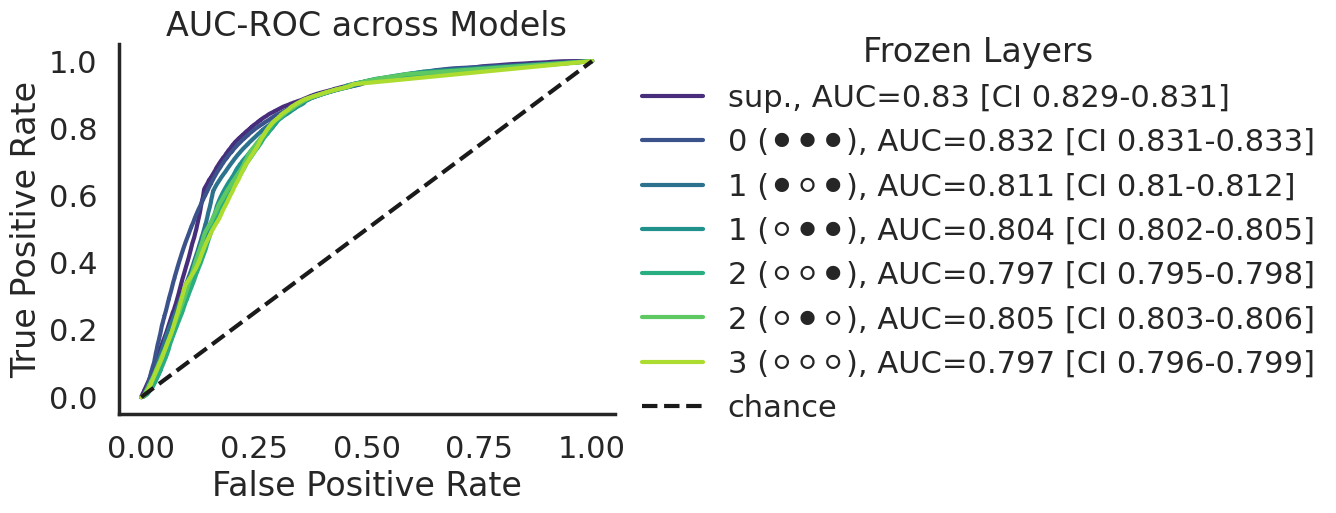

In [51]:
""# sns.set_palette('Greens', n_colors=7)
# sns.set_palette(reversed(sns.color_palette("viridis", n_colors=7)), 7)
sns.set_palette(sns.color_palette("viridis", n_colors=7))


model_number = 0
for model_path in models:
    print("Working with {} ({})...\n".format(model_path, names[model_number]))
    # load models one by one
    pretrained_model = tf.keras.models.load_model(model_path, compile=False)  # compile=False as we use the model only for inference

    probs = pretrained_model.predict(np_test[0])
    predictions = np.argmax(probs, axis=1)

    fpr, tpr, _ = metrics.roc_curve(
        np_test[1][:,1],
        pretrained_model.predict(np_test[0])[:,1]
    )
    general_auc = np.round(metrics.roc_auc_score(np_test[1][:,1], pretrained_model.predict(np_test[0])[:,1], average='micro'), 3)
    # general_auc = np.round(metrics.roc_auc_score(np_test[1], pretrained_model.predict(np_test[0]), average='micro'), 3)
    print("AUC for {}: {}".format(names[model_number], general_auc))
    low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], pretrained_model.predict(np_test[0]), metric='AUROC')
    print("{}, AUC={} [CI {}-{}]".format(names[model_number], str(general_auc), round(low_CI_binary, 3), round(high_CI_binary, 3)))
    plt.plot(fpr, tpr, label="{}, AUC={} [CI {}-{}]".format(names[model_number], str(general_auc), round(low_CI_binary, 3), round(high_CI_binary, 3)))
    # plt.plot(fpr, tpr, label="{}, AUC={}".format(names[model_number], str(general_auc)))
    model_number+=1
# Join all AUC-ROC curves
plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.title('AUC-ROC across Models')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(title='Frozen Layers', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.grid(False)
sns.despine()
# if dataset=="MESA":
#     dataset = "MESA_AUC"
plt.savefig(os.path.join(dataset, 'AUCROC.pdf'), bbox_inches='tight')

In [52]:
pretrained_model.predict(np_test[0])

array([[0.24636646, 0.7536335 ],
       [0.23133193, 0.76866806],
       [0.19296756, 0.8070324 ],
       ...,
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]], dtype=float32)

Working with ..\Supervised\MESA\20231204-074617_l2_e200_esTrue_bs64_wTrue\supervised.finetuned.0.59.hdf5 (sup.)...

Working with ..\SimCLR\MESA\20231201-090723_e200_esTrue_bs128_wTrue_f0\simclr.frozen.6.26.hdf5 (0 (⚫⚫⚫))...

Working with ..\SimCLR\MESA\20231201-085552_e200_esTrue_bs128_wTrue_f1_m\simclr.frozen.16.93.hdf5 (1 (⚫⚪⚫))...

Working with ..\SimCLR\MESA\20231201-091643_e200_esTrue_bs128_wTrue_f1\simclr.frozen.9.05.hdf5 (1 (⚪⚫⚫))...

Working with ..\SimCLR\MESA\20231201-084504_e200_esTrue_bs128_wTrue_f2_fl\simclr.frozen.16.12.hdf5 (2 (⚪⚪⚫))...

Working with ..\SimCLR\MESA\20231201-092528_e200_esTrue_bs128_wTrue_f2\simclr.frozen.11.65.hdf5 (2 (⚪⚫⚪))...

Working with ..\SimCLR\MESA\20231201-093337_e200_esTrue_bs128_wTrue_f3\simclr.frozen.25.36.hdf5 (3 (⚪⚪⚪))...


findfont: Font family ['Work Sans Regural'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Work Sans Regural'] not found. Falling back to DejaVu Sans.


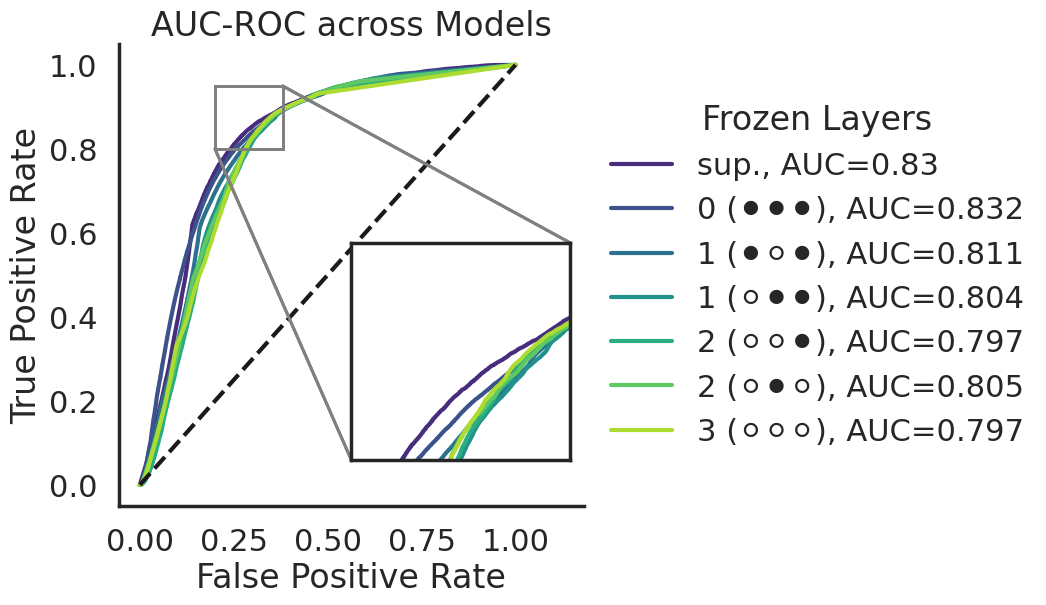

In [21]:
# sns.set_palette('Greens', n_colors=7)
# sns.set_palette(reversed(sns.color_palette("viridis", n_colors=7)), 7)
sns.set_palette(sns.color_palette("viridis", n_colors=7))

model_number = 0
# Zoomed-in view
fig, ax = plt.subplots(figsize=(6, 6))
axins = ax.inset_axes([0.5, 0.1, 0.47, 0.47])  # adjust the zoomed-in area

for model_path in models:
    print("Working with {} ({})...\n".format(model_path, names[model_number]))
    # load models one by one
    pretrained_model = tf.keras.models.load_model(model_path, compile=False)  # compile=False as we use the model only for inference

    probs = pretrained_model.predict(np_test[0])
    predictions = np.argmax(probs, axis=1)

    fpr, tpr, _ = metrics.roc_curve(
        np_test[1][:,1],
        pretrained_model.predict(np_test[0])[:,1]
    )
    general_auc = np.round(metrics.roc_auc_score(np_test[1][:,1], pretrained_model.predict(np_test[0])[:,1], average='micro'), 3)
    # low_CI_binary, high_CI_binary = get_ci_auc(np_test[1], pretrained_model.predict(np_test[0]), metric='AUROC')
    # plt.plot(fpr, tpr, label="{}, AUC={} [CI {}-{}]".format(names[model_number], str(general_auc), round(low_CI_binary, 2), round(high_CI_binary, 2)))
    ax.plot(fpr, tpr, label="{}, AUC={}".format(names[model_number], str(general_auc)))
    model_number+=1


    # Find the middle point of the ROC curves
    middle_index = len(fpr) // 2
    middle_fpr = fpr[middle_index]
    middle_tpr = tpr[middle_index]

    # Plot the zoomed-in area
    axins.plot(fpr, tpr)
    axins.set_xlim(0.2, 0.38)
    axins.set_ylim(0.8, 0.95)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    ax.indicate_inset_zoom(axins)

# Join all AUC-ROC curves
plt.plot([0, 1], [0, 1], 'k--', label='chance')  # random predictions curve

#create ROC curve
plt.title('AUC-ROC across Models')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
# plt.legend(
h,l = ax.get_legend_handles_labels()
plt.legend(h[0:7], l[0:7], title='Frozen Layers', loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.grid(False)
sns.despine()
plt.savefig(os.path.join(dataset, 'AUCROC-zoom-2.pdf'), bbox_inches='tight')

## Plotting conditioned AUC-ROC

In [ ]:
os.getcwd()

In [ ]:
auc = pd.read_csv(os.path.join(dataset, 'aucroc_metrics.csv'), delimiter=';')
auc.head()

In [ ]:
auc = auc.melt(id_vars=['Protected Attribute', 'Segments'], value_vars=['Supervised', '0', '1m', '1f', '2fl', '2fm', '3'])
auc.rename(columns={'variable': 'Model'}, inplace=True)
auc

In [ ]:
import re

auc.loc[:, "ci"] = auc.loc[:, "value"].apply(lambda v: str.split(v, ' ')[1])
auc.loc[:, 'CI_lb'] = pd.to_numeric(auc.loc[:, 'ci'].apply(lambda ci: re.findall("\d+\.\d+", ci)[0]))
auc.loc[:, 'CI_ub'] = pd.to_numeric(auc.loc[:, 'ci'].apply(lambda ci: re.findall("\d+\.\d+", ci)[1]))
auc.loc[:, "value"] = pd.to_numeric(auc.loc[:, "value"].apply(lambda v: str.split(v, ' ')[0]))
auc.loc[:, "yerr_lb"] = auc.value-auc.CI_lb
auc.loc[:, "yerr_ub"] = auc.CI_ub-auc.value

In [ ]:
auc

In [ ]:
auc.to_csv(os.path.join(dataset, 'auroc_metrics_edited.csv'))

In [ ]:
# given some mean values and their confidence intervals,
# means = np.array(auc.Supervised)
# lb  = np.array(auc.Supervised_CI_lb)
# ub  = np.array(auc.Supervised_CI_ub)
#
# # calculate the error
# yerr = np.c_[means-lb,ub-means ].T
# print (yerr) # prints [[ 6 10  8  9]
#              #         [ 5 10  7  8]]
#
# # and plot it on a bar chart
# plt.bar(range(len(means)), means, yerr=yerr)
# plt.xticks(range(len(means)))
# plt.show()


In [ ]:
# sns.set(style='white', context="poster", font='Work Sans Regural')

# calculate errors
means = np.array(auc.value)
lb  = np.array(auc.CI_lb)
ub  = np.array(auc.CI_ub)

# calculate the error
yerr = np.c_[means-lb,ub-means ].T
print (yerr.shape)

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=auc, kind="bar",
    # join=False,
    # capsize=.3, color=".5",
    x="value", y="Segments", hue="Model", palette="dark",
    alpha=.7, height=6,
    yerr = lambda x: x
    # yerr=yerr,
)
plot_errorbars(lambda x: (x.min(), x.max()))
g.set_xticklabels(rotation=90)
g.despine(left=True)
g.set_axis_labels("", "AUC ROC")
g.legend.set_title("Protected Attribute")

In [ ]:
# Create the catplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Use 'pointplot' to create the catplot
ax = sns.pointplot(data=auc, x="value", y="Segments", hue="Model", dodge=True, join=False, ci=None)

# Customize error bars using 'yerr' parameter
for i, bar in enumerate(ax.containers):
    lower_errors = auc["yerr_lb"][auc["Model"] == ax.hues[i]]
    upper_errors = auc["yerr_ub"][auc["Model"] == ax.hues[i]]
    ax.errorbar(bar.get_xdata(), bar.get_ydata(), yerr=[lower_errors, upper_errors], fmt='none', ecolor='k', capsize=5)

# Add labels and a legend
plt.xlabel("Value")
plt.ylabel("Segments")
plt.legend(title="Model")

# Show the plot
plt.show()

In [ ]:
# Concatenate "Protected Attribute" and "Segments" to create a new column for the y-axis
auc['Combined_Y'] = auc['Protected Attribute'] + ' - ' + auc['Segments']

# Create the catplot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Use 'pointplot' to create the catplot
ax = sns.pointplot(data=auc, x="value", y="Combined_Y", hue="Model", dodge=.8 - .8 / 3, join=False, ci=None)

# Customize error bars using 'yerr' parameter
for i, bar in enumerate(ax.containers):
    lower_errors = auc["CI_lb"][auc["Model"] == ax.hues[i]]
    upper_errors = auc["CI_ub"][auc["Model"] == ax.hues[i]]
    ax.errorbar(bar.get_xdata(), bar.get_ydata(), yerr=[lower_errors, upper_errors], fmt='none', ecolor='k', capsize=5)

# Add labels and a legend
plt.xlabel("Value")
plt.ylabel("Protected Attribute - Segments")
plt.legend(title="Model")

# Show the plot
plt.show()

In [ ]:
# Concatenate "Protected Attribute" and "Segments" to create a new column for the y-axis
auc['Combined_Y'] = auc['Protected Attribute'] + ' - ' + auc['Segments']

# Create the catplot
sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))

# Use 'pointplot' to create the catplot
ax = sns.catplot(data=auc, kind='bar', x="value", y="Combined_Y", hue="Model", dodge=.8 - .8 / 3, ci=None)

# Customize error bars using 'yerr' parameter
for i, bar in enumerate(ax.containers):
    lower_errors = auc["CI_lb"][auc["Model"] == ax.hues[i]]
    upper_errors = auc["CI_ub"][auc["Model"] == ax.hues[i]]
    ax.errorbar(bar.get_xdata(), bar.get_ydata(), yerr=[lower_errors, upper_errors], fmt='none', ecolor='k', capsize=5)

# Add labels and a legend
plt.xlabel("Value")
plt.ylabel("Protected Attribute - Segments")
plt.legend(title="Model")

# Show the plot
plt.show()

In [ ]:
auc['Combined_Y'] = auc['Protected Attribute'] + ' - ' + auc['Segments']
lower = auc["CI_lb"].to_numpy()
upper = auc["CI_ub"].to_numpy()

xerror = [lower, upper]

# Create the catplot
sns.set(style="whitegrid")
# plt.figure(figsize=(10, 6))

fig, ax = plt.subplots()
fig.set_figheight(15)
fig.set_figwidth(17)
# Use 'pointplot' to create the catplot
ax.errorbar('value', 'Combined_Y', marker='o', data=auc, xerr=xerror)
ax.fill_between(auc.value, auc.CI_lb, auc.CI_ub, color = 'b', alpha = .1)


# Add labels and a legend
plt.xlabel("Value")
plt.ylabel("Protected Attribute - Segments")

# Show the plot
plt.show()

In [ ]:
lower = auc["CI_lb"].to_numpy()
upper = auc["CI_ub"].to_numpy()

yerror = [lower, upper]

plt.errorbar(auc["Combined_Y"], auc["value"], yerr=yerror, capsize=5)
plt.xticks(rotation=90)

In [ ]:
sns.plotting_context("poster")

## Plotting Sensitivity (Recall)

In [ ]:
perf_df

In [ ]:
recall = perf_df.loc[perf_df.metric == "Recall"]
recall

In [ ]:
plt.bar(data=recall, x="tag", height="value")
plt.xticks(rotation=90)

## Sample size vs Performance Correlation

In [18]:
df_corr = pd.read_excel('SampleSizeVSPerformance.xlsx')
df_corr

,Dataset,Attribute,Segment,Sample size,Percentage,SegmentVSGeneral,Performance,Model
0,GLOBEM,Disability,No,7547,0.929205,-0.004,0.530,Supervised
1,GLOBEM,Disability,Yes,575,0.070795,0.079,0.613,Supervised
2,GLOBEM,Ethnicity/Race,White,2477,0.306180,0.117,0.651,Supervised
3,GLOBEM,Ethnicity/Race,Black,178,0.022002,NaN,NaN,Supervised
4,GLOBEM,Ethnicity/Race,Asian,4062,0.502101,-0.038,0.496,Supervised
...,...,...,...,...,...,...,...,...
65,MIMIC,Insurance,Medicaid,1763,0.083400,-0.043,0.786,SSL
66,MIMIC,Insurance,Government,496,0.023464,0.066,0.895,SSL
67,MIMIC,Insurance,Self Pay,182,0.008610,0.115,0.944,SSL
68,MIMIC,Lanuage,English,11890,0.866681,0.002,0.831,SSL


In [19]:
max_performance = df_corr.groupby(by=['Dataset', 'Model']).Performance.max()
min_performance = df_corr.groupby(by=['Dataset', 'Model']).Performance.min()

def normalize_performance(row, max_performance, min_performance):
    # print(row)
    min = min_performance[row["Dataset"]][row["Model"]]
    max = max_performance[row["Dataset"]][row["Model"]]
    return (row["Performance"] - min)/(max-min)

df_corr.loc[:, 'Normalized Performance'] = df_corr.apply(lambda row: normalize_performance(row, max_performance, min_performance), axis=1)
df_corr.loc[:, "Absolute Difference (Segment vs. General)"] = abs(df_corr["SegmentVSGeneral"])
df_corr

,Dataset,Attribute,Segment,Sample size,Percentage,SegmentVSGeneral,Performance,Model,Normalized Performance,Absolute Difference (Segment vs. General)
0,GLOBEM,Disability,No,7547,0.929205,-0.004,0.530,Supervised,0.698254,0.004
1,GLOBEM,Disability,Yes,575,0.070795,0.079,0.613,Supervised,0.905237,0.079
2,GLOBEM,Ethnicity/Race,White,2477,0.306180,0.117,0.651,Supervised,1.000000,0.117
3,GLOBEM,Ethnicity/Race,Black,178,0.022002,NaN,NaN,Supervised,NaN,NaN
4,GLOBEM,Ethnicity/Race,Asian,4062,0.502101,-0.038,0.496,Supervised,0.613466,0.038
...,...,...,...,...,...,...,...,...,...,...
65,MIMIC,Insurance,Medicaid,1763,0.083400,-0.043,0.786,SSL,0.145946,0.043
66,MIMIC,Insurance,Government,496,0.023464,0.066,0.895,SSL,0.735135,0.066
67,MIMIC,Insurance,Self Pay,182,0.008610,0.115,0.944,SSL,1.000000,0.115
68,MIMIC,Lanuage,English,11890,0.866681,0.002,0.831,SSL,0.389189,0.002


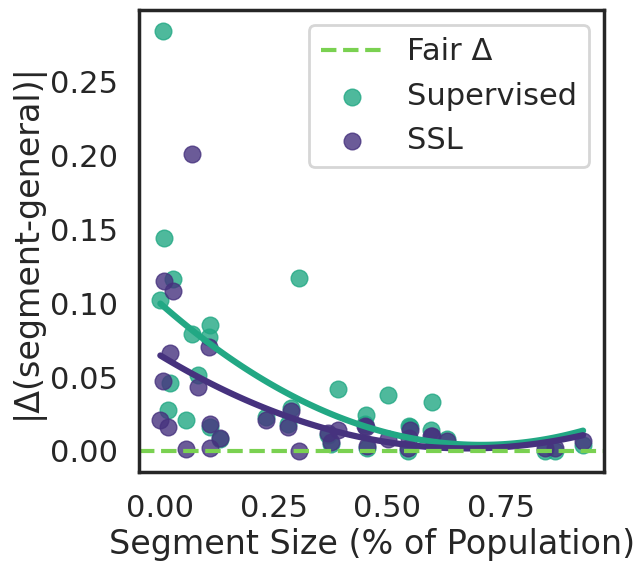

In [54]:
# sns.scatterplot(data=df_corr, x='Percentage', y='Absolute Difference (Segment vs. General)', palette="viridis", hue="Model", alpha=0.8)
# plt.xlabel("Segment Size (% of Population)")
# plt.ylabel("|Δ(segment-general)|")
# plt.axhline(0.0, ls='--', label='Fair Δ')

# two models
df1 = df_corr.loc[df_corr.Model == "Supervised", :]
df2 = df_corr.loc[df_corr.Model == "SSL", :]
# create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))
# add the plots for each dataframe
sns.regplot(x='Percentage', y='Absolute Difference (Segment vs. General)', data=df1, fit_reg=True, ci=None, ax=ax, order=2, color="#22a884ff", label='Supervised')
sns.regplot(x='Percentage', y='Absolute Difference (Segment vs. General)', data=df2, fit_reg=True, ci=None, ax=ax, order=2, label='SSL')
ax.set(ylabel="|Δ(segment-general)|", xlabel="Segment Size (% of Population)")
plt.axhline(0.0, ls='--', color="#7ad151ff", label='Fair Δ')
# sns.set_palette('viridis')
# plt.viridis()
ax.legend()
# plt.show()

plt.savefig('sampleVSperformanceCORR.pdf', bbox_inches='tight')
# plt.ylim((-0.1,0.4))
# todo add lowess curve
# todo add transparency to points
# todo try also with absolute difference before lowess curves

In [31]:
df_corr.dropna(subset=["SegmentVSGeneral"], inplace=True)
df_corr

,Dataset,Attribute,Segment,Sample size,Percentage,SegmentVSGeneral,Performance,Model,Normalized Performance,Absolute Difference (Segment vs. General)
0,GLOBEM,Disability,No,7547,0.929205,-0.004,0.530,Supervised,0.698254,0.004
1,GLOBEM,Disability,Yes,575,0.070795,0.079,0.613,Supervised,0.905237,0.079
2,GLOBEM,Ethnicity/Race,White,2477,0.306180,0.117,0.651,Supervised,1.000000,0.117
4,GLOBEM,Ethnicity/Race,Asian,4062,0.502101,-0.038,0.496,Supervised,0.613466,0.038
5,GLOBEM,Ethnicity/Race,Hispanic/Latinx,472,0.058344,0.021,0.555,Supervised,0.760599,0.021
...,...,...,...,...,...,...,...,...,...,...
65,MIMIC,Insurance,Medicaid,1763,0.083400,-0.043,0.786,SSL,0.145946,0.043
66,MIMIC,Insurance,Government,496,0.023464,0.066,0.895,SSL,0.735135,0.066
67,MIMIC,Insurance,Self Pay,182,0.008610,0.115,0.944,SSL,1.000000,0.115
68,MIMIC,Lanuage,English,11890,0.866681,0.002,0.831,SSL,0.389189,0.002


In [49]:
x = df_corr["Percentage"]
y = df_corr["Absolute Difference (Segment vs. General)"]

In [50]:
import scipy.stats
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.kendalltau(x, y))

(-0.5169697256103447, 8.823063300670663e-06)
SpearmanrResult(correlation=-0.6664229691929892, pvalue=1.01139094318395e-09)
KendalltauResult(correlation=-0.4870112780359068, pvalue=1.1235500893107882e-08)


In [61]:
x = df_corr.loc[df_corr.Model=="SSL", "Percentage"]
y = df_corr.loc[df_corr.Model=="SSL", "Absolute Difference (Segment vs. General)"]

In [62]:
import scipy.stats
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.kendalltau(x, y))

(-0.493063157390514, 0.0035518381136399567)
SpearmanrResult(correlation=-0.626818336667314, pvalue=9.498647832973751e-05)
KendalltauResult(correlation=-0.45715032088249435, pvalue=0.00019816822597868203)


In [63]:
x = df_corr.loc[df_corr.Model=="Supervised", "Percentage"]
y = df_corr.loc[df_corr.Model=="Supervised", "Absolute Difference (Segment vs. General)"]

In [64]:
import scipy.stats
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x, y))
print(scipy.stats.kendalltau(x, y))

(-0.5579980617692479, 0.0007403909164434715)
SpearmanrResult(correlation=-0.7144768035565978, pvalue=3.008793795833217e-06)
KendalltauResult(correlation=-0.5337153664193044, pvalue=1.325529970105831e-05)


In [65]:
"{:.8f}".format(float("8.823063300670663e-06"))

'0.00000882'

## Data Efficiency

In [124]:
# dataset = 'MIMIC'
# models = [
#     os.path.join(root_path, dataset, '20231211-111258_e100_esFalse_bs128_wTrue_f1_m_ss10', 'simclr.frozen.1.45.hdf5'),
#     os.path.join(root_path, dataset, '20231211-111328_e100_esFalse_bs128_wTrue_f1_m_ss20', 'simclr.frozen.1.35.hdf5'),
#     os.path.join(root_path, dataset, '20231211-111357_e100_esFalse_bs128_wTrue_f1_m_ss40', 'simclr.frozen.1.21.hdf5'),
#     os.path.join(root_path, dataset, '20231211-111428_e100_esFalse_bs128_wTrue_f1_m_ss60', 'simclr.frozen.1.18.hdf5'),
#     os.path.join(root_path, dataset, '20231211-111500_e100_esFalse_bs128_wTrue_f1_m_ss80', 'simclr.frozen.1.18.hdf5'),
#     os.path.join(root_path, dataset, '20231211-111533_e100_esFalse_bs128_wTrue_f1_m_ss100', 'simclr.frozen.1.09.hdf5'),
# ]

In [125]:
df

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Parity Deviation,Frozen Layers,Trainable Parameters,label_frozen
1,LANGUAGE,disparate_impact,2.008159,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,1.008159,3,120,3 (⚪⚪⚪)
5,LANGUAGE,error_rate_ratio,1.555921,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.555921,3,120,3 (⚪⚪⚪)
6,LANGUAGE,false_discovery_rate_ratio,0.815500,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.184500,3,120,3 (⚪⚪⚪)
7,LANGUAGE,false_negative_rate_ratio,0.769209,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.230791,3,120,3 (⚪⚪⚪)
8,LANGUAGE,false_omission_rate_ratio,1.629450,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10,0.629450,3,120,3 (⚪⚪⚪)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,AGE,error_rate_ratio,0.940552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.059448,3,120,3 (⚪⚪⚪)
523,AGE,false_discovery_rate_ratio,0.831184,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.168816,3,120,3 (⚪⚪⚪)
524,AGE,false_negative_rate_ratio,0.914010,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.085990,3,120,3 (⚪⚪⚪)
525,AGE,false_omission_rate_ratio,1.550552,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150,0.550552,3,120,3 (⚪⚪⚪)


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

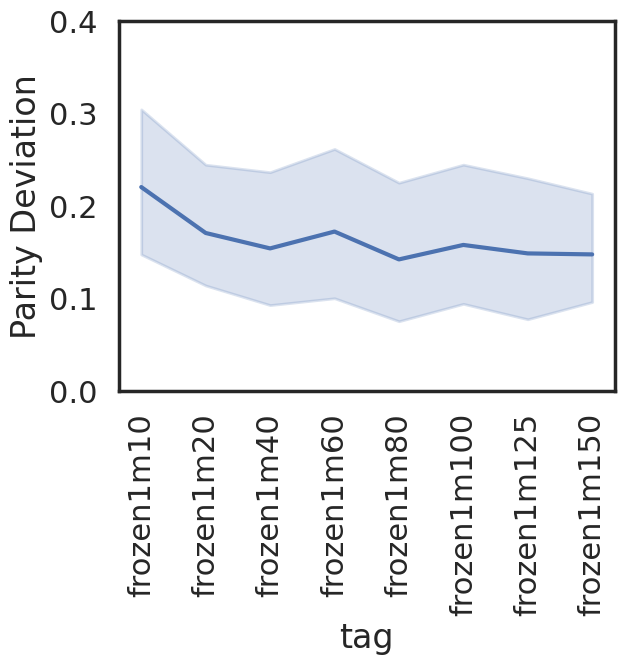

In [126]:
sns.lineplot(data=df, x='tag', y='Parity Deviation', err_style='band')
plt.ylim((0,0.4))
plt.xticks(rotation=90)

In [127]:
per = per.loc[per.metric == 'AUROC']
per

,metric,value,low_ci,high_ci,parameters,model_name,subfolder,added_layers,frozen_layers,tag
2,AUROC,0.624019,0.588737,0.661466,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m10
12,AUROC,0.679322,0.646305,0.710991,120322,simclr.frozen.1.35.hdf5,20231211-111328_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m20
22,AUROC,0.703184,0.671568,0.727342,120322,simclr.frozen.1.21.hdf5,20231211-111357_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m40
32,AUROC,0.743573,0.711220,0.772374,120322,simclr.frozen.1.18.hdf5,20231211-111428_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m60
42,AUROC,0.732837,0.704029,0.759216,120322,simclr.frozen.1.18.hdf5,20231211-111500_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m80
52,AUROC,0.767865,0.740590,0.791604,120322,simclr.frozen.1.09.hdf5,20231211-111533_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m100
62,AUROC,0.763375,0.734987,0.789250,120322,simclr.frozen.1.15.hdf5,20231213-142041_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m125
72,AUROC,0.774168,0.750051,0.798430,120322,simclr.frozen.1.11.hdf5,20231213-143219_e100_esFalse_bs128_wTrue_f1_m_...,2,1,frozen1m150


([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

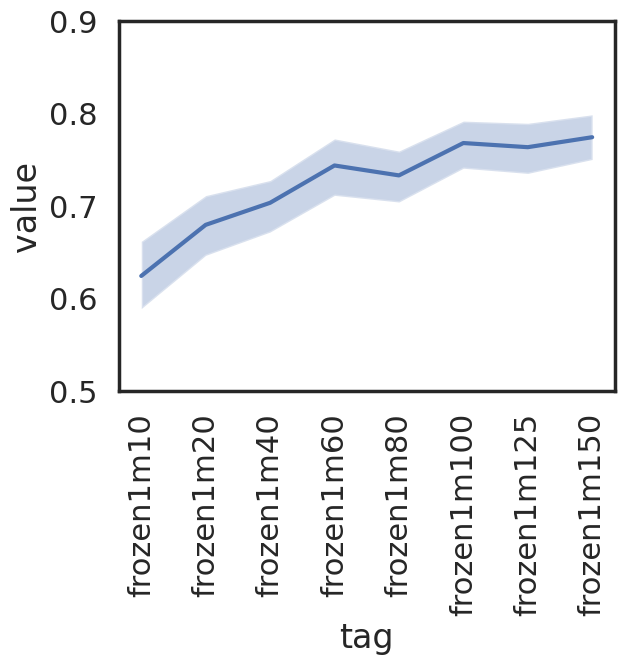

In [128]:
sns.lineplot(data=per, x='tag', y='value')
lower_bound = per['low_ci']
upper_bound = per['high_ci']
plt.fill_between(per.tag, lower_bound, upper_bound, alpha=.3)
plt.ylim((0.5,0.9))
plt.xticks(rotation=90)

In [129]:
prefix = 'SS_sup_'
dfsup = pd.read_csv(os.path.join(dataset, '{}fairness_metrics.csv'.format(prefix)))
persup = pd.read_csv(os.path.join(dataset, '{}ci_metrics.csv'.format(prefix)))
dfsup.loc[:, 'Paradigm'] = 'Supervised'
df.loc[:, 'Paradigm'] = 'SSL'
persup.loc[:, 'Paradigm'] = 'Supervised'
per.loc[:, 'Paradigm'] = 'SSL'

# keep same metrics as with SimCLR models
dfsup = dfsup[dfsup.metric.isin(['false_omission_rate_ratio', 'disparate_impact', 'error_rate_ratio', 'false_discovery_rate_ratio', 'false_negative_rate_ratio', 'false_positive_rate_ratio'])]
persup = persup.loc[persup.metric == 'AUROC']
# Calculate deviation from statistical parity (1.0)
dfsup.loc[:, "value"].astype(float)
dfsup.loc[:, "Parity Deviation"] = abs(1-dfsup.value)
dfsup

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Paradigm,Parity Deviation
1,LANGUAGE,disparate_impact,2.021945,153154,supervised.finetuned.0.43.hdf5,20231213-112301_l2_e100_esFalse_bs64_wTrue_ss10,2,NaN,supervised10,Supervised,1.021945
5,LANGUAGE,error_rate_ratio,1.557078,153154,supervised.finetuned.0.43.hdf5,20231213-112301_l2_e100_esFalse_bs64_wTrue_ss10,2,NaN,supervised10,Supervised,0.557078
6,LANGUAGE,false_discovery_rate_ratio,0.802760,153154,supervised.finetuned.0.43.hdf5,20231213-112301_l2_e100_esFalse_bs64_wTrue_ss10,2,NaN,supervised10,Supervised,0.197240
7,LANGUAGE,false_negative_rate_ratio,0.787042,153154,supervised.finetuned.0.43.hdf5,20231213-112301_l2_e100_esFalse_bs64_wTrue_ss10,2,NaN,supervised10,Supervised,0.212958
8,LANGUAGE,false_omission_rate_ratio,1.636352,153154,supervised.finetuned.0.43.hdf5,20231213-112301_l2_e100_esFalse_bs64_wTrue_ss10,2,NaN,supervised10,Supervised,0.636352
...,...,...,...,...,...,...,...,...,...,...,...
522,AGE,error_rate_ratio,1.007082,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,Supervised,0.007082
523,AGE,false_discovery_rate_ratio,0.821429,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,Supervised,0.178571
524,AGE,false_negative_rate_ratio,0.956522,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,Supervised,0.043478
525,AGE,false_omission_rate_ratio,1.648968,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,Supervised,0.648968


In [130]:
import re
regex = r"[0-9]+$"
persup.loc[:, 'Samples'] = persup.tag.apply(lambda v: re.findall(regex, v)[0])
per.loc[:, 'Samples'] = per.tag.apply(lambda v: re.findall(regex, v)[0])
df.loc[:, 'Samples'] = df.tag.apply(lambda v: re.findall(regex, v)[0])
dfsup.loc[:, 'Samples'] = dfsup.tag.apply(lambda v: re.findall(regex, v)[0])
persup

,metric,value,low_ci,high_ci,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Paradigm,Samples
2,AUROC,0.756109,0.731032,0.783471,153154,supervised.finetuned.0.43.hdf5,20231213-112301_l2_e100_esFalse_bs64_wTrue_ss10,2,NaN,supervised10,Supervised,10
12,AUROC,0.766614,0.740896,0.791025,153154,supervised.finetuned.0.47.hdf5,20231213-112340_l2_e100_esFalse_bs64_wTrue_ss20,2,NaN,supervised20,Supervised,20
22,AUROC,0.762624,0.736922,0.786070,153154,supervised.finetuned.0.53.hdf5,20231213-112417_l2_e100_esFalse_bs64_wTrue_ss40,2,NaN,supervised40,Supervised,40
32,AUROC,0.798697,0.774044,0.821678,153154,supervised.finetuned.0.53.hdf5,20231213-112511_l2_e100_esFalse_bs64_wTrue_ss60,2,NaN,supervised60,Supervised,60
42,AUROC,0.796703,0.771619,0.817886,153154,supervised.finetuned.0.56.hdf5,20231213-112635_l2_e100_esFalse_bs64_wTrue_ss80,2,NaN,supervised80,Supervised,80
52,AUROC,0.798732,0.772979,0.821577,153154,supervised.finetuned.0.55.hdf5,20231213-112727_l2_e100_esFalse_bs64_wTrue_ss100,2,NaN,supervised100,Supervised,100
62,AUROC,0.808952,0.785819,0.830353,153154,supervised.finetuned.0.59.hdf5,20231213-141939_l2_e100_esFalse_bs64_wTrue_ss125,2,NaN,supervised125,Supervised,125
72,AUROC,0.806354,0.782822,0.829786,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,Supervised,150


In [131]:
performance = pd.concat([per, persup])
fairness = pd.concat([df, dfsup])
fairness

,protected_attribute,metric,value,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Parity Deviation,Frozen Layers,Trainable Parameters,label_frozen,Paradigm,Samples
1,LANGUAGE,disparate_impact,2.008159,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m10,1.008159,3,120.0,3 (⚪⚪⚪),SSL,10
5,LANGUAGE,error_rate_ratio,1.555921,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m10,0.555921,3,120.0,3 (⚪⚪⚪),SSL,10
6,LANGUAGE,false_discovery_rate_ratio,0.815500,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m10,0.184500,3,120.0,3 (⚪⚪⚪),SSL,10
7,LANGUAGE,false_negative_rate_ratio,0.769209,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m10,0.230791,3,120.0,3 (⚪⚪⚪),SSL,10
8,LANGUAGE,false_omission_rate_ratio,1.629450,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m10,0.629450,3,120.0,3 (⚪⚪⚪),SSL,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,AGE,error_rate_ratio,1.007082,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,0.007082,NaN,NaN,NaN,Supervised,150
523,AGE,false_discovery_rate_ratio,0.821429,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,0.178571,NaN,NaN,NaN,Supervised,150
524,AGE,false_negative_rate_ratio,0.956522,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,0.043478,NaN,NaN,NaN,Supervised,150
525,AGE,false_omission_rate_ratio,1.648968,153154,supervised.finetuned.0.58.hdf5,20231213-143305_l2_e100_esFalse_bs64_wTrue_ss150,2,NaN,supervised150,0.648968,NaN,NaN,NaN,Supervised,150


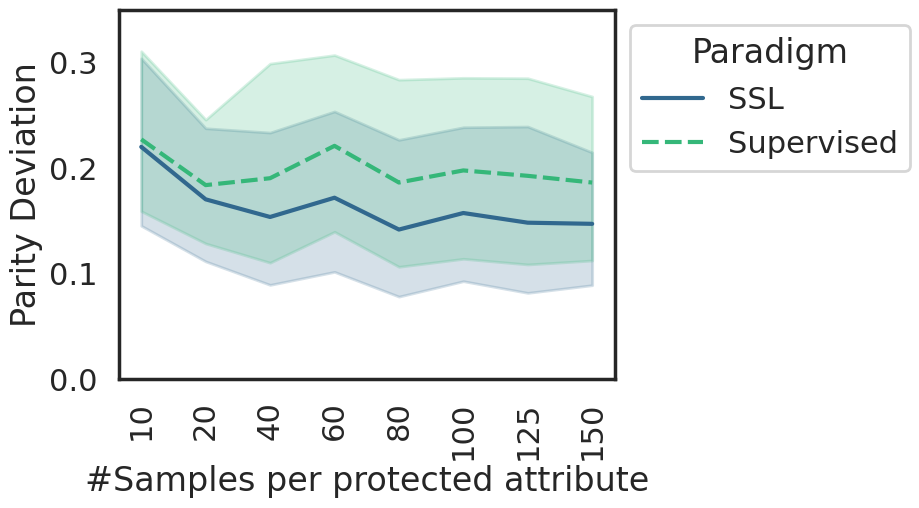

In [135]:
fairness.reset_index(inplace=True, drop=True)
ax = sns.lineplot(data=fairness, x='Samples', y='Parity Deviation', err_style='band', hue='Paradigm', style='Paradigm', palette='viridis')
plt.ylim((0.0,0.35))
plt.xticks(rotation=90)
plt.xlabel('#Samples per protected attribute')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('dataEfficiencyVSFairness.pdf', bbox_inches='tight')

In [36]:
performance

,metric,value,low_ci,high_ci,parameters,model_name,subfolder,added_layers,frozen_layers,tag,Paradigm,Samples
2,AUROC,0.624019,0.588737,0.661466,120322,simclr.frozen.1.45.hdf5,20231211-111258_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m10,SSL,10
12,AUROC,0.679322,0.646305,0.710991,120322,simclr.frozen.1.35.hdf5,20231211-111328_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m20,SSL,20
22,AUROC,0.703184,0.671568,0.727342,120322,simclr.frozen.1.21.hdf5,20231211-111357_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m40,SSL,40
32,AUROC,0.743573,0.711220,0.772374,120322,simclr.frozen.1.18.hdf5,20231211-111428_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m60,SSL,60
42,AUROC,0.732837,0.704029,0.759216,120322,simclr.frozen.1.18.hdf5,20231211-111500_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m80,SSL,80
52,AUROC,0.767865,0.740590,0.791604,120322,simclr.frozen.1.09.hdf5,20231211-111533_e100_esFalse_bs128_wTrue_f1_m_...,2,1.0,frozen1m100,SSL,100
2,AUROC,0.756109,0.731032,0.783471,153154,supervised.finetuned.0.43.hdf5,20231213-112301_l2_e100_esFalse_bs64_wTrue_ss10,2,NaN,supervised10,Supervised,10
12,AUROC,0.766614,0.740896,0.791025,153154,supervised.finetuned.0.47.hdf5,20231213-112340_l2_e100_esFalse_bs64_wTrue_ss20,2,NaN,supervised20,Supervised,20
22,AUROC,0.762624,0.736922,0.786070,153154,supervised.finetuned.0.53.hdf5,20231213-112417_l2_e100_esFalse_bs64_wTrue_ss40,2,NaN,supervised40,Supervised,40
32,AUROC,0.798697,0.774044,0.821678,153154,supervised.finetuned.0.53.hdf5,20231213-112511_l2_e100_esFalse_bs64_wTrue_ss60,2,NaN,supervised60,Supervised,60


ValueError: operands could not be broadcast together with shapes (12,) (6,) 

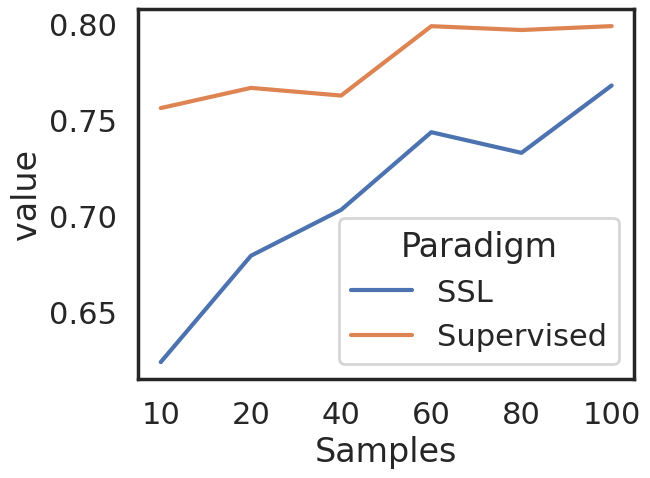

In [37]:
performance.reset_index(inplace=True, drop=True)
sns.lineplot(data=performance, x='Samples', y='value', hue='Paradigm')
lower_bound = per['low_ci']
upper_bound = per['high_ci']
plt.fill_between(performance.Samples, lower_bound, upper_bound, alpha=.3)
plt.xticks(rotation=90)